In [2]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms

# ---- CONFIG ----
ROOT = "/Users/ishabhansali/Downloads/resnet_project/cleaned"  # Adjust if your notebook is not in RESNET_PROJECT root
TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR = os.path.join(ROOT, "Testing")
NUM_CLIENTS = 4
LOCAL_TEST_FRAC = 0.2
SEED = 77

# ---- REPRODUCIBILITY ----
def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# ---- PATH CHECKS ----
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"ROOT folder not found: {ROOT}")
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Testing directory not found: {TEST_DIR}")

print("Training classes:", os.listdir(TRAIN_DIR))
print("Testing classes:", os.listdir(TEST_DIR))

# ---- TRANSFORM AND LOAD ----
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ---- IID PARTITION ----
num_items = len(train_dataset)
client_lengths = [num_items // NUM_CLIENTS] * NUM_CLIENTS
client_lengths[0] += num_items - sum(client_lengths)  # Add remainder to first client

from torch.utils.data import random_split

client_subsets = random_split(train_dataset, client_lengths, generator=torch.Generator().manual_seed(SEED))
print("Client samples:", [len(subset) for subset in client_subsets])

# ---- TEST SPLIT FOR EACH CLIENT ----
client_data = []
for c in client_subsets:
    n_test = int(len(c) * LOCAL_TEST_FRAC)
    n_train = len(c) - n_test
    tr, te = random_split(c, [n_train, n_test], generator=torch.Generator().manual_seed(SEED))
    client_data.append((tr, te))
    print(f"Client train: {n_train}, test: {n_test}")

# ---- SAMPLE ACCESS ----
image, label = client_data[0][0][0]  # First sample from client 0 train set
print("First client, first train label:", label)


Training classes: ['pituitary', 'notumor', 'glioma', 'meningioma']
Testing classes: ['pituitary', 'notumor', 'glioma', 'meningioma']
Train samples: 5712, Test samples: 1311
Client samples: [1428, 1428, 1428, 1428]
Client train: 1143, test: 285
Client train: 1143, test: 285
Client train: 1143, test: 285
Client train: 1143, test: 285
First client, first train label: 0


In [3]:
# Get class names from the underlying ImageFolder
class_names = train_dataset.classes

# Count samples per class for each client
for idx, (client_train, _) in enumerate(client_data):
    # Extract all labels for this client's training subset
    labels = [client_train[i][1] for i in range(len(client_train))]
    # Count occurrences of each label
    counts = {class_name: labels.count(i) for i, class_name in enumerate(class_names)}
    print(f"Client {idx}:")
    for class_name in class_names:
        print(f"  {class_name}: {counts[class_name]} samples")
    print("-" * 30)


Client 0:
  glioma: 243 samples
  meningioma: 294 samples
  notumor: 310 samples
  pituitary: 296 samples
------------------------------
Client 1:
  glioma: 303 samples
  meningioma: 242 samples
  notumor: 309 samples
  pituitary: 289 samples
------------------------------
Client 2:
  glioma: 259 samples
  meningioma: 265 samples
  notumor: 310 samples
  pituitary: 309 samples
------------------------------
Client 3:
  glioma: 253 samples
  meningioma: 260 samples
  notumor: 344 samples
  pituitary: 286 samples
------------------------------


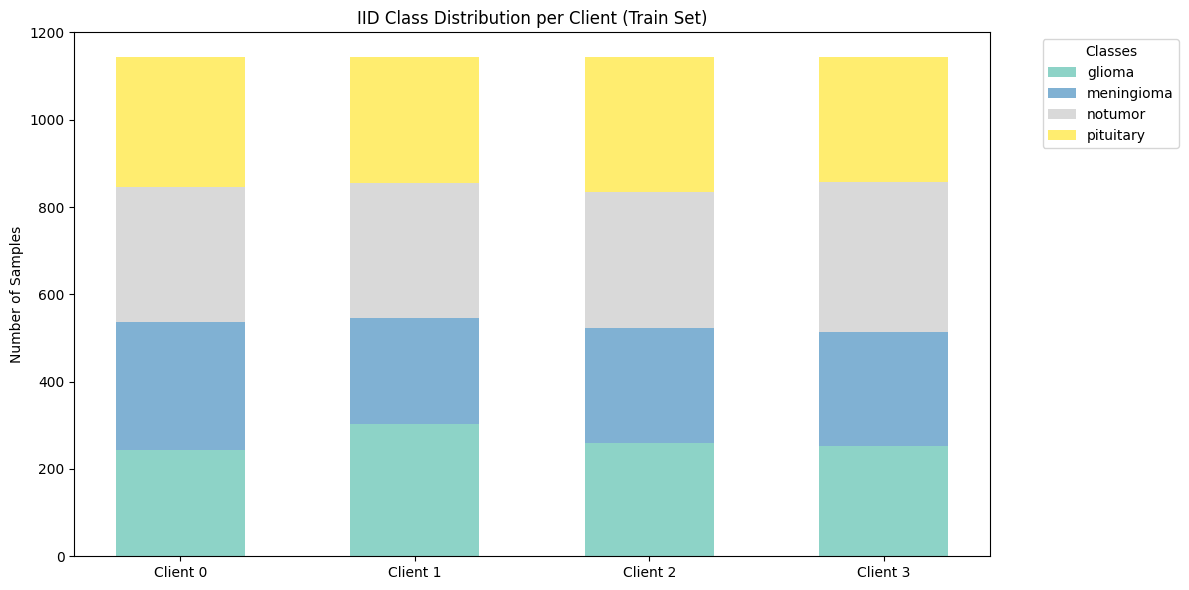

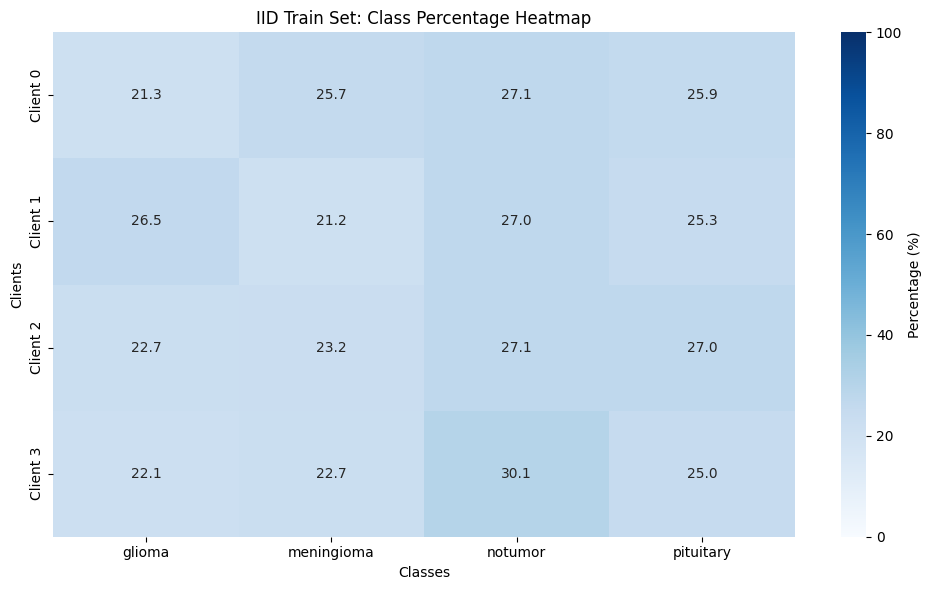

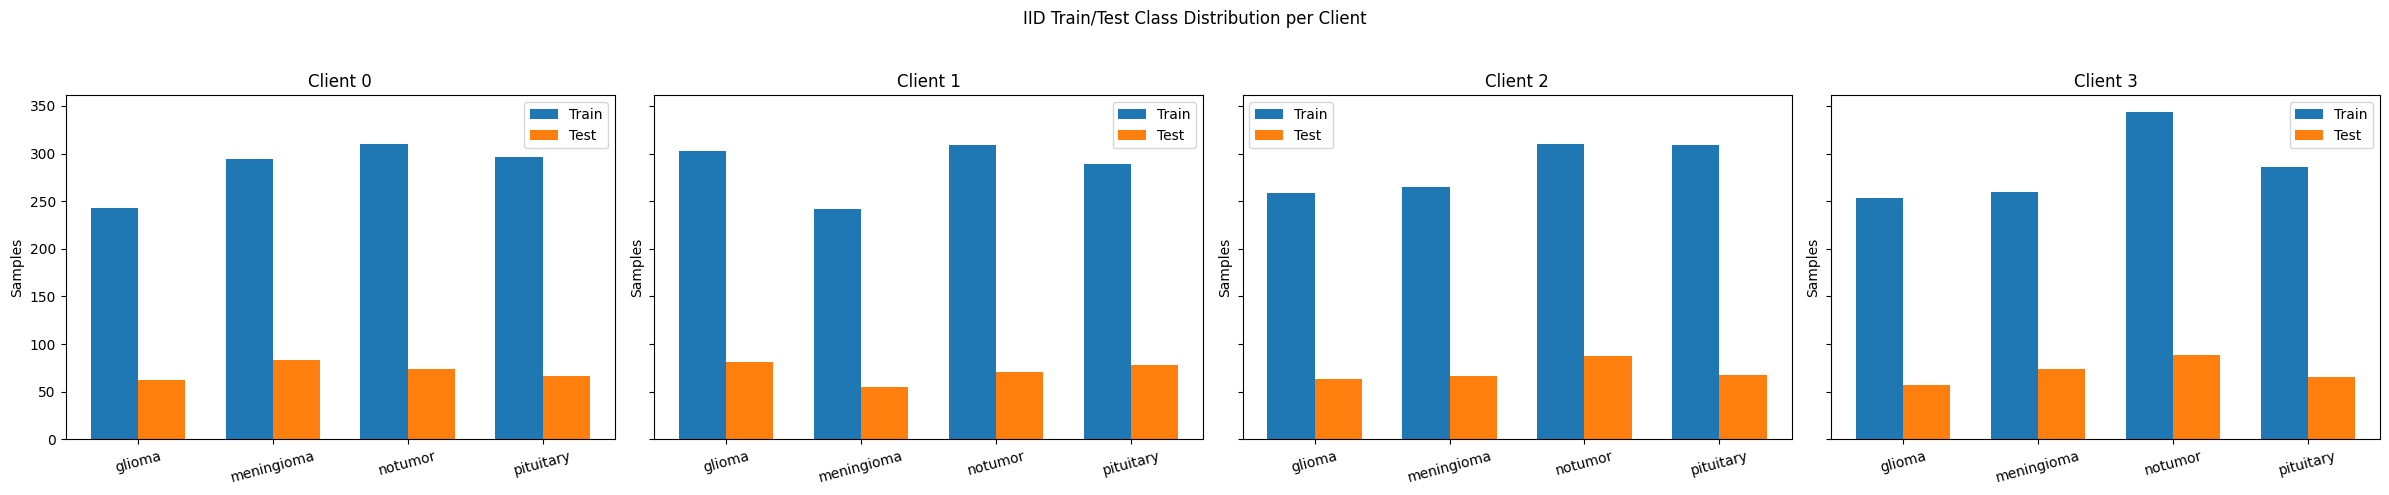

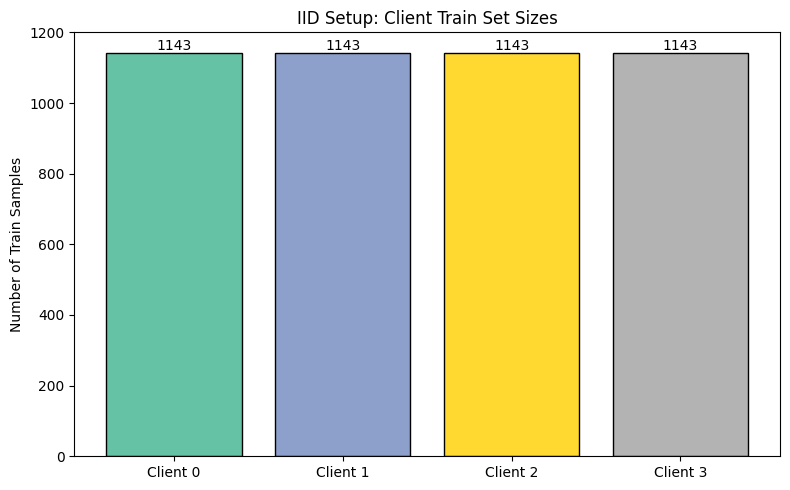

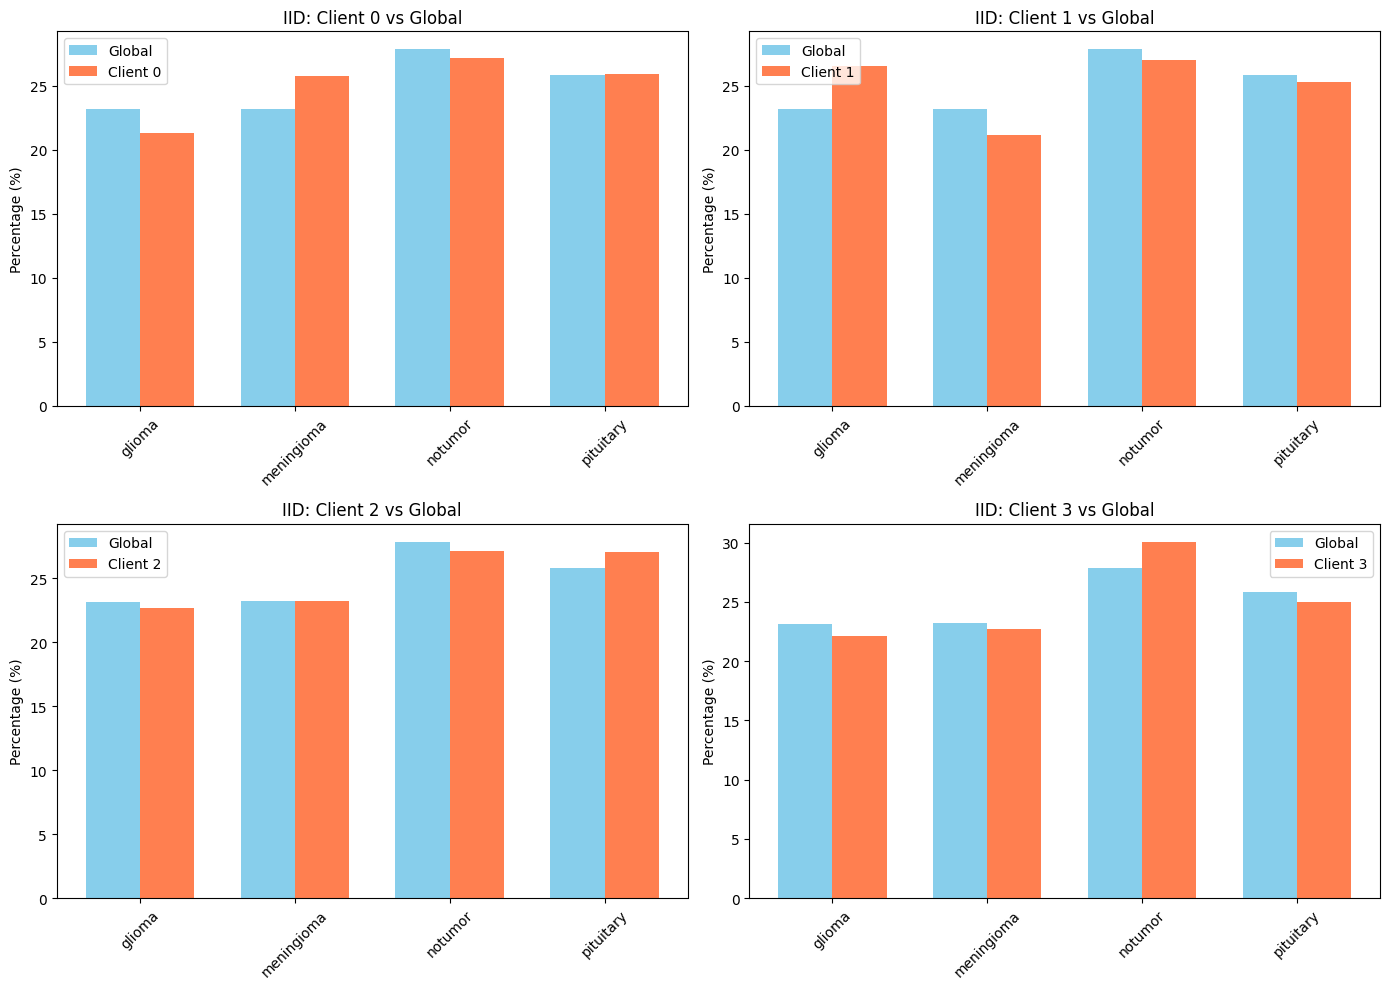


IID DATA DISTRIBUTION SUMMARY (Train)

Client 0: 1143 samples
  glioma: 243 (21.3%)
  meningioma: 294 (25.7%)
  notumor: 310 (27.1%)
  pituitary: 296 (25.9%)

Client 1: 1143 samples
  glioma: 303 (26.5%)
  meningioma: 242 (21.2%)
  notumor: 309 (27.0%)
  pituitary: 289 (25.3%)

Client 2: 1143 samples
  glioma: 259 (22.7%)
  meningioma: 265 (23.2%)
  notumor: 310 (27.1%)
  pituitary: 309 (27.0%)

Client 3: 1143 samples
  glioma: 253 (22.1%)
  meningioma: 260 (22.7%)
  notumor: 344 (30.1%)
  pituitary: 286 (25.0%)

Global Distribution (Train Set):
  glioma: 1058 (23.1%)
  meningioma: 1061 (23.2%)
  notumor: 1273 (27.8%)
  pituitary: 1180 (25.8%)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================================
#              1. Class Count per Client (Train Only)
# ============================================================
client_class_dist = []

for client_train, _ in client_data:  # only train split
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = [labels.count(i) for i in range(len(class_names))]
    client_class_dist.append(counts)

num_clients = len(client_class_dist)
num_classes = len(class_names)

# ----- Plot: stacked bar chart -----
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(num_clients)
bottom = np.zeros(num_clients)

colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

for class_idx in range(num_classes):
    values = [client_class_dist[c][class_idx] for c in range(num_clients)]
    ax.bar(x, values, bottom=bottom, width=0.55, 
           color=colors[class_idx], label=class_names[class_idx])
    bottom += np.array(values)

ax.set_xticks(x)
ax.set_xticklabels([f"Client {i}" for i in range(num_clients)])
ax.set_ylabel("Number of Samples")
ax.set_title("IID Class Distribution per Client (Train Set)")
ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ============================================================
#              2. Heatmap of Class Percentages
# ============================================================
heatmap_data = []
for counts in client_class_dist:
    total = sum(counts)
    row = [100 * c / total if total > 0 else 0 for c in counts]
    heatmap_data.append(row)
heatmap_data = np.array(heatmap_data)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data, annot=True, fmt=".1f", cmap="Blues", 
    xticklabels=class_names, 
    yticklabels=[f"Client {i}" for i in range(num_clients)],
    cbar_kws={'label': 'Percentage (%)'},
    vmin=0, vmax=100
)
plt.title("IID Train Set: Class Percentage Heatmap")
plt.xlabel("Classes")
plt.ylabel("Clients")
plt.tight_layout()
plt.show()

# ============================================================
#              3. Train/Test Counts per Client
# ============================================================
client_train_counts = []
client_test_counts = []

for train_subset, test_subset in client_data:
    train_labels = [train_subset[i][1] for i in range(len(train_subset))]
    test_labels  = [test_subset[i][1]  for i in range(len(test_subset))]
    
    train_counts = [train_labels.count(i) for i in range(num_classes)]
    test_counts  = [test_labels.count(i)  for i in range(num_classes)]
    
    client_train_counts.append(train_counts)
    client_test_counts.append(test_counts)

client_train_counts = np.array(client_train_counts)
client_test_counts = np.array(client_test_counts)

fig, axs = plt.subplots(1, num_clients, figsize=(6 * num_clients, 5), sharey=True)
x = np.arange(num_classes)
width = 0.35

for idx in range(num_clients):
    axs[idx].bar(x - width/2, client_train_counts[idx], width, label="Train", color='tab:blue')
    axs[idx].bar(x + width/2, client_test_counts[idx], width, label="Test",  color='tab:orange')
    
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(class_names, rotation=15)
    axs[idx].set_title(f"Client {idx}")
    axs[idx].set_ylabel("Samples")
    axs[idx].legend()

plt.suptitle("IID Train/Test Class Distribution per Client")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ============================================================
#              4. Client Dataset Sizes
# ============================================================
client_sizes = [sum(c) for c in client_class_dist]

plt.figure(figsize=(8,5))
bars = plt.bar(
    [f"Client {i}" for i in range(num_clients)],
    client_sizes, 
    color=plt.cm.Set2(np.linspace(0,1,num_clients)),
    edgecolor="black"
)
plt.ylabel("Number of Train Samples")
plt.title("IID Setup: Client Train Set Sizes")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f"{int(height)}",
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()

# ============================================================
#              5. Global vs Client Distribution
# ============================================================
global_counts = np.sum(client_class_dist, axis=0)
global_total = np.sum(global_counts)
global_percent = [100 * c/global_total for c in global_counts]

fig, axes = plt.subplots(2, (num_clients+1)//2, figsize=(14,10))
axes = axes.flatten()

for idx in range(num_clients):
    client_total = sum(client_class_dist[idx])
    client_percent = [100*c/client_total for c in client_class_dist[idx]]

    x_pos = np.arange(num_classes)
    width = 0.35

    axes[idx].bar(x_pos - width/2, global_percent, width, label="Global", color='skyblue')
    axes[idx].bar(x_pos + width/2, client_percent, width, label=f"Client {idx}", color='coral')

    axes[idx].set_title(f"IID: Client {idx} vs Global")
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(class_names, rotation=45)
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].legend()

plt.tight_layout()
plt.show()

# ============================================================
#              6. Summary Statistics
# ============================================================
print("\n" + "="*50)
print("IID DATA DISTRIBUTION SUMMARY (Train)")
print("="*50)

for idx, counts in enumerate(client_class_dist):
    total = sum(counts)
    print(f"\nClient {idx}: {total} samples")
    for class_idx, class_name in enumerate(class_names):
        pct = 100 * counts[class_idx] / total
        print(f"  {class_name}: {counts[class_idx]} ({pct:.1f}%)")

print("\n" + "="*50)
print("Global Distribution (Train Set):")
print("="*50)
for class_idx, class_name in enumerate(class_names):
    pct = 100 * global_counts[class_idx] / global_total
    print(f"  {class_name}: {global_counts[class_idx]} ({pct:.1f}%)")
print("="*50)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution_iid(client_subsets, class_names):
    num_clients = len(client_subsets)
    num_classes = len(class_names)

    # Count per-class samples for each client
    dist_matrix = np.zeros((num_clients, num_classes), dtype=int)

    for client_id, subset in enumerate(client_subsets):
        labels = [subset[i][1] for i in range(len(subset))]
        for cls in range(num_classes):
            dist_matrix[client_id, cls] = labels.count(cls)

    # ----------- Plot Bar Chart -----------
    x = np.arange(num_clients)
    width = 0.2   # width of each bar

    plt.figure(figsize=(10,5))

    for cls in range(num_classes):
        plt.bar(x + cls*width, dist_matrix[:, cls], width, label=class_names[cls])

    plt.xticks(x + width, [f"client_{i}" for i in range(num_clients)])
    plt.ylabel("Number of Images")
    plt.title("Class Distribution per Client (IID Partition)")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.show()

    return dist_matrix


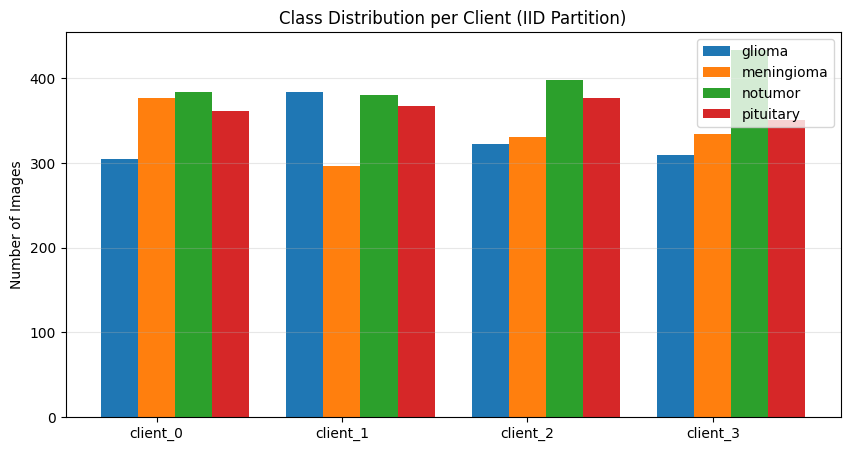

In [6]:
class_distribution_iid = plot_class_distribution_iid(client_subsets, class_names)


In [7]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# -----------------------------------------
# 1. Prepare class distributions per client
# -----------------------------------------
num_classes = len(train_dataset.classes)
num_clients = len(client_subsets)

client_distributions = []

for k in range(num_clients):
    subset = client_subsets[k]
    counts = np.zeros(num_classes)

    for i in range(len(subset)):
        class_idx = subset[i][1]
        counts[class_idx] += 1

    # Normalize to probabilities
    prob_vec = counts / counts.sum() if counts.sum() > 0 else counts
    client_distributions.append(prob_vec)

# -----------------------------------------
# 2. Compute global distribution
# -----------------------------------------
global_counts = np.zeros(num_classes)

for _, cls_idx in train_dataset.samples:
    global_counts[cls_idx] += 1

global_dist = global_counts / global_counts.sum()

print("Global Class Distribution:", global_dist)
print("Classes:", train_dataset.classes)

# -----------------------------------------
# 3. Compute JS Divergence per client
# -----------------------------------------
print("\n" + "="*70)
print("JENSEN-SHANNON DIVERGENCE (Client vs Global) — IID Setup")
print("="*70)
print("Range: 0 (identical) to 1 (completely different)\n")

js_values = []
for k, dist in enumerate(client_distributions):
    js = jensenshannon(global_dist, dist)
    js_values.append(js)
    print(f"Client {k}: JS Divergence = {js:.4f}")

print(f"\nAverage JS Divergence: {np.mean(js_values):.4f}")


Global Class Distribution: [0.23126751 0.23441877 0.27923669 0.25507703]
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

JENSEN-SHANNON DIVERGENCE (Client vs Global) — IID Setup
Range: 0 (identical) to 1 (completely different)

Client 0: JS Divergence = 0.0258
Client 1: JS Divergence = 0.0344
Client 2: JS Divergence = 0.0078
Client 3: JS Divergence = 0.0201

Average JS Divergence: 0.0220


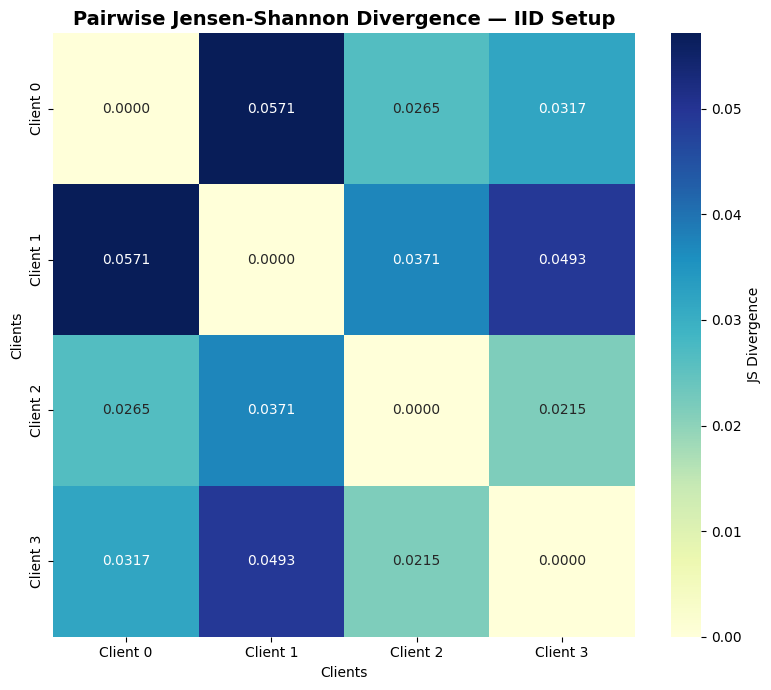

In [8]:
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns

num_clients = len(client_subsets)
num_classes = len(train_dataset.classes)

# -----------------------------------------
# 1. Compute probability distribution per client
# -----------------------------------------
client_dists = []

for subset in client_subsets:
    counts = np.zeros(num_classes)
    
    labels = [subset[i][1] for i in range(len(subset))]
    for cls in labels:
        counts[cls] += 1

    prob = counts / counts.sum() if counts.sum() > 0 else counts
    client_dists.append(prob)

# -----------------------------------------
# 2. Compute pairwise JS matrix
# -----------------------------------------
pairwise_js = np.zeros((num_clients, num_clients))

for i in range(num_clients):
    for j in range(num_clients):
        pairwise_js[i, j] = jensenshannon(client_dists[i], client_dists[j])

# -----------------------------------------
# 3. Heatmap
# -----------------------------------------
plt.figure(figsize=(8, 7))
sns.heatmap(
    pairwise_js, annot=True, fmt=".4f", cmap="YlGnBu",
    xticklabels=[f"Client {i}" for i in range(num_clients)],
    yticklabels=[f"Client {i}" for i in range(num_clients)],
    cbar_kws={'label': 'JS Divergence'}
)
plt.title("Pairwise Jensen-Shannon Divergence — IID Setup", fontsize=14, fontweight="bold")
plt.xlabel("Clients")
plt.ylabel("Clients")
plt.tight_layout()
plt.show()


In [9]:
# ============================================================
#             FEDAVG (IID) — PRETRAINED RESNET18
# ============================================================

import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader


# ============================================================
#                    DEVICE SETUP (REUSE / DEFINE)
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥 Using CPU")


# ============================================================
#            CONFIG (IID FEDAVG — PRETRAINED RESNET18)
# ============================================================
SEED_IID = 77
NUM_ROUNDS_IID = 30
LOCAL_EPOCHS_IID = 5
LR_IID = 3e-4
BATCH_SIZE_IID = 32

NUM_CLIENTS_IID = len(client_data)            # from your IID partition code
NUM_CLASSES_IID = len(train_dataset.classes)  # from your dataset


# Reproducibility
random.seed(SEED_IID)
np.random.seed(SEED_IID)
torch.manual_seed(SEED_IID)
torch.cuda.manual_seed_all(SEED_IID)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce_iid = nn.CrossEntropyLoss()


# ============================================================
#     PRETRAINED RESNET18 WITH FREEZING STRATEGY (IID)
# ============================================================
def create_pretrained_resnet18_iid(num_classes: int) -> nn.Module:
    """
    Same architecture + freezing strategy as the moderate non-IID setup,
    but kept separate for clarity in the IID experiment.
    """
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze early layers
    for p in model.conv1.parameters():
        p.requires_grad = False
    for p in model.bn1.parameters():
        p.requires_grad = False
    for p in model.layer1.parameters():
        p.requires_grad = False
    for p in model.layer2.parameters():
        p.requires_grad = False

    # Train deeper layers
    for p in model.layer3.parameters():
        p.requires_grad = True
    for p in model.layer4.parameters():
        p.requires_grad = True

    # Replace FC head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    return model


# ============================================================
#                TRAINING + EVALUATION (IID)
# ============================================================
def train_one_epoch_iid(model, loader, device, optimizer):
    model.train()
    tot_loss = 0.0
    tot_corr = 0
    tot = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = crit_ce_iid(logits, y)
        loss.backward()
        optimizer.step()

        batch_size = x.size(0)
        tot_loss += loss.item() * batch_size
        tot_corr += (logits.argmax(1) == y).sum().item()
        tot += batch_size

    return {"loss": tot_loss / tot, "acc": tot_corr / tot}


@torch.no_grad()
def evaluate_iid(model, loader, device):
    model.eval()
    tot_loss = 0.0
    tot_corr = 0
    tot = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = crit_ce_iid(logits, y)

        batch_size = x.size(0)
        tot_loss += loss.item() * batch_size
        tot_corr += (logits.argmax(1) == y).sum().item()
        tot += batch_size

    return {"loss": tot_loss / tot, "acc": tot_corr / tot}


# ============================================================
#        BUILD CLIENT TRAIN + LOCAL TEST LOADERS (IID)
# ============================================================
client_train_loaders_iid = []
client_test_loaders_iid = []

for train_subset, test_subset in client_data:  # from your IID partition code
    client_train_loaders_iid.append(
        DataLoader(train_subset, batch_size=BATCH_SIZE_IID, shuffle=True)
    )
    client_test_loaders_iid.append(
        DataLoader(test_subset, batch_size=BATCH_SIZE_IID, shuffle=False)
    )

# Global holdout loader from the Testing directory
holdout_loader_iid = DataLoader(
    test_dataset, batch_size=BATCH_SIZE_IID, shuffle=False
)


# ============================================================
#        GLOBAL MODEL INITIALIZATION (IID)
# ============================================================
global_model_iid = create_pretrained_resnet18_iid(NUM_CLASSES_IID).to(DEVICE)

best_acc_iid = -1.0
best_state_iid = None

metrics_history_fedavg_iid_pretrained = {
    "round": [],
    "holdout": [],
    "clients": {k: [] for k in range(NUM_CLIENTS_IID)},
}


# ============================================================
#                     FEDAVG TRAINING LOOP (IID)
# ============================================================
for rnd in range(NUM_ROUNDS_IID):

    print(f"\n🔁 [IID] FedAvg Pretrained Round {rnd + 1}/{NUM_ROUNDS_IID}")

    local_states = []

    # ----- CLIENT TRAINING -----
    for k in range(NUM_CLIENTS_IID):

        local_model = copy.deepcopy(global_model_iid).to(DEVICE)

        optimizer = optim.Adam(
            (p for p in local_model.parameters() if p.requires_grad),
            lr=LR_IID,
        )

        for ep in range(LOCAL_EPOCHS_IID):
            train_metrics = train_one_epoch_iid(
                local_model, client_train_loaders_iid[k], DEVICE, optimizer
            )

        # Save model params (on CPU for aggregation)
        local_states.append(
            {name: param.cpu() for name, param in local_model.state_dict().items()}
        )

        # Per-client evaluation on *local* client test subset
        client_metric = evaluate_iid(local_model, client_test_loaders_iid[k], DEVICE)
        metrics_history_fedavg_iid_pretrained["clients"][k].append(client_metric)

        print(
            f"  Client {k} | "
            f"Train Loss: {train_metrics['loss']:.4f}, "
            f"Train Acc: {train_metrics['acc']:.4f}, "
            f"Local Test Acc: {client_metric['acc']:.4f}"
        )

    # ----- FEDAVG AGGREGATION -----
    new_state = {}
    global_state_keys = global_model_iid.state_dict().keys()

    for key in global_state_keys:
        stacked = torch.stack([state[key] for state in local_states], dim=0)

        if stacked.dtype.is_floating_point:
            new_state[key] = stacked.mean(dim=0)
        else:
            # e.g. num_batches_tracked (integers) — just take from first client
            new_state[key] = stacked[0]

    global_model_iid.load_state_dict(new_state)

    # ----- GLOBAL HOLDOUT EVAL (Using TEST_DIR as holdout) -----
    holdout_metric = evaluate_iid(global_model_iid, holdout_loader_iid, DEVICE)

    metrics_history_fedavg_iid_pretrained["round"].append(rnd + 1)
    metrics_history_fedavg_iid_pretrained["holdout"].append(holdout_metric)

    print(
        f"🌍 [IID] Global Holdout | "
        f"Acc: {holdout_metric['acc']:.4f}, "
        f"Loss: {holdout_metric['loss']:.4f}"
    )

    # ----- SAVE BEST GLOBAL MODEL (IID) -----
    if holdout_metric["acc"] > best_acc_iid:
        best_acc_iid = holdout_metric["acc"]
        best_state_iid = copy.deepcopy(global_model_iid.state_dict())
        print(f"💾 [IID] New BEST Model Saved! Acc = {best_acc_iid:.4f}")


# ============================================================
#                   SAVE OUTPUTS (IID)
# ============================================================
torch.save(best_state_iid, "best_fedavg_iid_pretrained.pth")
np.save(
    "metrics_history_fedavg_iid_pretrained.npy",
    metrics_history_fedavg_iid_pretrained,
)

print("\n✅ [IID] Saved:")
print("   • best_fedavg_iid_pretrained.pth")
print("   • metrics_history_fedavg_iid_pretrained.npy")


🚀 Using Apple Silicon GPU (MPS)

🔁 [IID] FedAvg Pretrained Round 1/30
  Client 0 | Train Loss: 0.0189, Train Acc: 0.9939, Local Test Acc: 0.9333
  Client 1 | Train Loss: 0.0120, Train Acc: 0.9974, Local Test Acc: 0.9263
  Client 2 | Train Loss: 0.0542, Train Acc: 0.9816, Local Test Acc: 0.9439
  Client 3 | Train Loss: 0.0120, Train Acc: 0.9974, Local Test Acc: 0.9368
🌍 [IID] Global Holdout | Acc: 0.9352, Loss: 0.1817
💾 [IID] New BEST Model Saved! Acc = 0.9352

🔁 [IID] FedAvg Pretrained Round 2/30
  Client 0 | Train Loss: 0.0197, Train Acc: 0.9948, Local Test Acc: 0.9404
  Client 1 | Train Loss: 0.0082, Train Acc: 0.9974, Local Test Acc: 0.9474
  Client 2 | Train Loss: 0.0074, Train Acc: 0.9974, Local Test Acc: 0.9579
  Client 3 | Train Loss: 0.0125, Train Acc: 0.9956, Local Test Acc: 0.9368
🌍 [IID] Global Holdout | Acc: 0.9748, Loss: 0.0780
💾 [IID] New BEST Model Saved! Acc = 0.9748

🔁 [IID] FedAvg Pretrained Round 3/30
  Client 0 | Train Loss: 0.0375, Train Acc: 0.9904, Local Test Acc

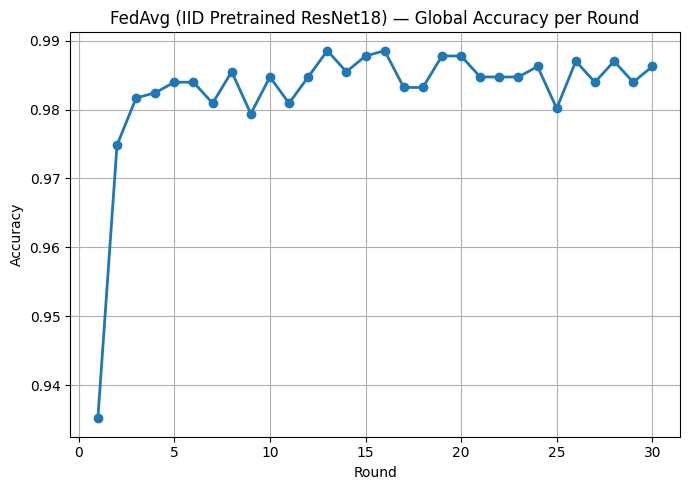

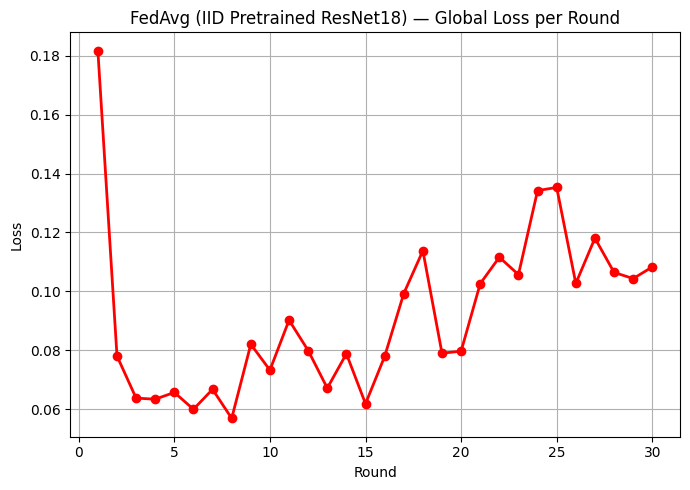

Saved: fedavg_iid_pretrained_rounds.npy, fedavg_iid_pretrained_acc.npy, fedavg_iid_pretrained_loss.npy

📊 FEDAVG IID PRETRAINED — GLOBAL HOLDOUT METRICS
Accuracy :  0.9886
Precision:  0.9878
Recall   :  0.9877
F1-Score :  0.9877


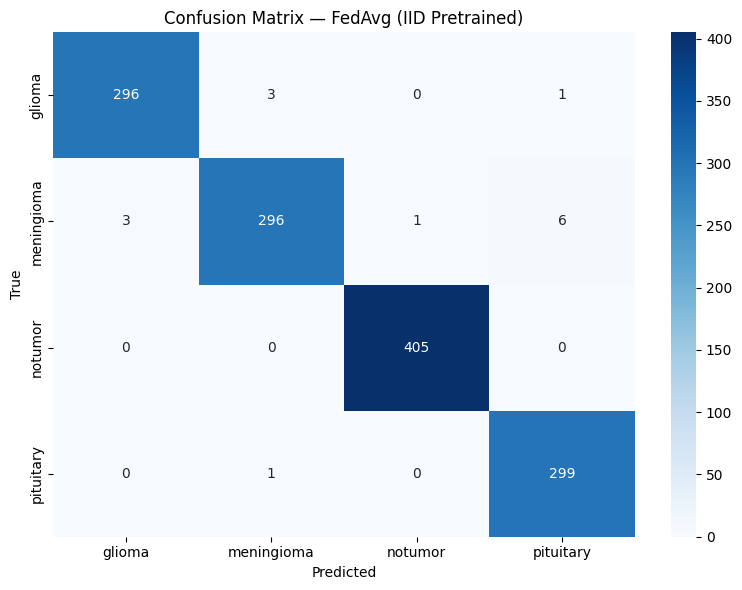


Saved confusion matrix → fedavg_iid_pretrained_confusion_matrix.npy


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# ============================================================
#      LOAD METRICS FROM FEDAVG PRETRAINED (IID RUN)
# ============================================================

rounds = metrics_history_fedavg_iid_pretrained["round"]
holdout_metrics = metrics_history_fedavg_iid_pretrained["holdout"]

accs = [m["acc"] for m in holdout_metrics]
losses = [m["loss"] for m in holdout_metrics]

# ============================================================
#                PLOT GLOBAL ACCURACY PER ROUND
# ============================================================

plt.figure(figsize=(7, 5))
plt.plot(rounds, accs, marker='o', linewidth=2)
plt.title("FedAvg (IID Pretrained ResNet18) — Global Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
#                PLOT GLOBAL LOSS PER ROUND
# ============================================================

plt.figure(figsize=(7, 5))
plt.plot(rounds, losses, marker='o', color="red", linewidth=2)
plt.title("FedAvg (IID Pretrained ResNet18) — Global Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
#         SAVE ROUND/ACC/LOSS ARRAYS FOR COMPARISON
# ============================================================

np.save("fedavg_iid_pretrained_rounds.npy", np.array(rounds))
np.save("fedavg_iid_pretrained_acc.npy", np.array(accs))
np.save("fedavg_iid_pretrained_loss.npy", np.array(losses))

print("Saved: fedavg_iid_pretrained_rounds.npy, fedavg_iid_pretrained_acc.npy, fedavg_iid_pretrained_loss.npy")

# ============================================================
#         LOAD BEST FEDAVG PRETRAINED IID MODEL
# ============================================================

best_model_iid = create_pretrained_resnet18_iid(NUM_CLASSES_IID)
best_model_iid.load_state_dict(torch.load("best_fedavg_iid_pretrained.pth"))
best_model_iid.to(DEVICE)
best_model_iid.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in holdout_loader_iid:   # <-- FIXED to correct loader name
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = best_model_iid(x)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# ============================================================
#                  HOLDOUT METRIC COMPUTATION
# ============================================================

acc = (all_preds == all_labels).mean()
prec = precision_score(all_labels, all_preds, average="macro")
rec = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print("\n📊 FEDAVG IID PRETRAINED — GLOBAL HOLDOUT METRICS")
print(f"Accuracy :  {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall   :  {rec:.4f}")
print(f"F1-Score :  {f1:.4f}")

# ============================================================
#                  CONFUSION MATRIX
# ============================================================

cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix — FedAvg (IID Pretrained)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ============================================================
#            SAVE CONFUSION MATRIX
# ============================================================

np.save("fedavg_iid_pretrained_confusion_matrix.npy", cm)
print("\nSaved confusion matrix → fedavg_iid_pretrained_confusion_matrix.npy")


In [12]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

# ============================================================
#                    DEVICE SELECTION
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥️ Using CPU (No GPU available)")

# ============================================================
#        CONFIG — FedProx + Pretrained ResNet18 (IID)
# ============================================================
SEED = 77
NUM_ROUNDS_IID_FP   = 30      # federated rounds
LOCAL_EPOCHS_IID_FP = 5       # local epochs per round
LR_IID_FP           = 3e-4    # learning rate
FEDPROX_MU_IID      = 1e-3    # μ for IID FedProx
BATCH_SIZE_IID_FP   = 32

NUM_CLIENTS_IID = len(client_data)        # list of (train_subset, test_subset)
NUM_CLASSES_IID = len(train_dataset.classes)

# ============================================================
#                    REPRODUCIBILITY
# ============================================================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce = nn.CrossEntropyLoss()

# ============================================================
#    PRETRAINED RESNET18 (SAME FREEZING AS OTHER EXPERIMENTS)
# ============================================================
def create_pretrained_resnet18_iid_fp(num_classes: int) -> nn.Module:
    """
    ResNet18 with ImageNet weights for IID FedProx.
    Freeze: conv1, bn1, layer1, layer2
    Train : layer3, layer4, fc
    """
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze earlier layers
    for p in model.conv1.parameters():  p.requires_grad = False
    for p in model.bn1.parameters():    p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Fine-tune deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace classifier head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

# ============================================================
#             FEDPROX LOCAL TRAIN FUNCTION (IID)
# ============================================================
def train_fedprox_epoch_iid(model, loader, device, optimizer, global_params, mu):
    """
    One local epoch of FedProx training for IID clients.
    global_params: dict[name -> tensor] from the global model.
    """
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = crit_ce(logits, y)

        # Proximal penalty
        prox_term = 0.0
        for name, param in model.named_parameters():
            if param.requires_grad:
                prox_term = prox_term + ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        total_loss    += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total         += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc":  total_correct / max(total, 1)
    }

# ============================================================
#                   EVALUATION (IID)
# ============================================================
@torch.no_grad()
def evaluate_iid_fp(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce(logits, y)

        total_loss    += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total         += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc":  total_correct / max(total, 1)
    }

# ============================================================
#        CLIENT TRAIN + TEST LOADERS (IID)
# ============================================================
client_train_loaders_iid_fp = []
client_test_loaders_iid_fp  = []

for train_subset, test_subset in client_data:
    client_train_loaders_iid_fp.append(
        DataLoader(train_subset, batch_size=BATCH_SIZE_IID_FP, shuffle=True,  num_workers=0)
    )
    client_test_loaders_iid_fp.append(
        DataLoader(test_subset, batch_size=BATCH_SIZE_IID_FP, shuffle=False, num_workers=0)
    )

# ============================================================
#        GLOBAL HOLDOUT / TEST LOADER (IID FedProx)
#   Uses the Testing directory (test_dataset) as global holdout,
#   consistent with your FedAvg setup.
# ============================================================
holdout_loader_iid_fp = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_IID_FP,
    shuffle=False,
    num_workers=0
)

print(f"Holdout (IID FedProx) size: {len(test_dataset)}")

# ============================================================
#             GLOBAL MODEL INIT (IID FedProx)
# ============================================================
global_model_iid_fp = create_pretrained_resnet18_iid_fp(NUM_CLASSES_IID).to(DEVICE)

best_global_acc_iid_fp   = -1.0
best_global_state_iid_fp = None

metrics_history_fedprox_pretrained_iid = {
    "round":   [],
    "holdout": [],                     # list of {"loss": ..., "acc": ...}
    "clients": {k: [] for k in range(NUM_CLIENTS_IID)}
}

# ============================================================
#                 FEDPROX TRAINING LOOP (IID)
# ============================================================
for rnd in range(NUM_ROUNDS_IID_FP):
    print(f"\n🔁 [IID] FedProx Pretrained Round {rnd+1}/{NUM_ROUNDS_IID_FP}")

    local_states = []

    # Cache current global params for proximal term
    global_params = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model_iid_fp.named_parameters()
    }

    # -------- LOCAL CLIENT TRAINING --------
    for k in range(NUM_CLIENTS_IID):
        local_model = copy.deepcopy(global_model_iid_fp).to(DEVICE)

        optimizer = optim.Adam(
            (p for p in local_model.parameters() if p.requires_grad),
            lr=LR_IID_FP
        )

        for _ in range(LOCAL_EPOCHS_IID_FP):
            train_fedprox_epoch_iid(
                local_model,
                client_train_loaders_iid_fp[k],
                DEVICE,
                optimizer,
                global_params,
                mu=FEDPROX_MU_IID
            )

        # Save local state dict on CPU
        local_states.append({
            name: param.cpu() for name, param in local_model.state_dict().items()
        })

        # Per-client evaluation (on its local test split)
        client_metric = evaluate_iid_fp(local_model, client_test_loaders_iid_fp[k], DEVICE)
        metrics_history_fedprox_pretrained_iid["clients"][k].append(client_metric)
        print(f"  Client {k} | Acc: {client_metric['acc']:.4f}")

    # -------- FEDERATED AVERAGING --------
    new_state = {}
    for key in global_model_iid_fp.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)
        if stacked.dtype.is_floating_point:
            new_state[key] = stacked.mean(dim=0)
        else:  # int/bool tensors
            new_state[key] = stacked[0]

    global_model_iid_fp.load_state_dict(new_state)

    # -------- GLOBAL HOLDOUT EVAL (TESTING SET) --------
    holdout_metric = evaluate_iid_fp(global_model_iid_fp, holdout_loader_iid_fp, DEVICE)
    metrics_history_fedprox_pretrained_iid["round"].append(rnd + 1)
    metrics_history_fedprox_pretrained_iid["holdout"].append(holdout_metric)

    print(f"🌍 IID FedProx Global | Loss: {holdout_metric['loss']:.4f} | "
          f"Acc: {holdout_metric['acc']:.4f}")

    # -------- SAVE BEST GLOBAL MODEL --------
    if holdout_metric["acc"] > best_global_acc_iid_fp:
        best_global_acc_iid_fp   = holdout_metric["acc"]
        best_global_state_iid_fp = copy.deepcopy(global_model_iid_fp.state_dict())
        print(f"💾 New BEST IID FedProx Model Saved! Acc = {best_global_acc_iid_fp:.4f}")

# ============================================================
#                 SAVE MODEL + METRICS (IID FedProx)
# ============================================================
if best_global_state_iid_fp is not None:
    torch.save(best_global_state_iid_fp, "best_fedprox_pretrained_iid.pth")
    print(f"\n✅ Best IID FedProx-pretrained model saved to best_fedprox_pretrained_iid.pth "
          f"(Acc = {best_global_acc_iid_fp:.4f})")
else:
    print("\n⚠️ No improvement — no IID FedProx-pretrained model saved.")

np.save(
    "metrics_history_fedprox_pretrained_iid.npy",
    metrics_history_fedprox_pretrained_iid,
    allow_pickle=True
)
print("📊 Metrics history saved to metrics_history_fedprox_pretrained_iid.npy")


🚀 Using Apple Silicon GPU (MPS)
Holdout (IID FedProx) size: 1311

🔁 [IID] FedProx Pretrained Round 1/30
  Client 0 | Acc: 0.9193
  Client 1 | Acc: 0.9193
  Client 2 | Acc: 0.9368
  Client 3 | Acc: 0.9263
🌍 IID FedProx Global | Loss: 0.1718 | Acc: 0.9352
💾 New BEST IID FedProx Model Saved! Acc = 0.9352

🔁 [IID] FedProx Pretrained Round 2/30
  Client 0 | Acc: 0.9509
  Client 1 | Acc: 0.9439
  Client 2 | Acc: 0.9649
  Client 3 | Acc: 0.9368
🌍 IID FedProx Global | Loss: 0.0858 | Acc: 0.9733
💾 New BEST IID FedProx Model Saved! Acc = 0.9733

🔁 [IID] FedProx Pretrained Round 3/30
  Client 0 | Acc: 0.9368
  Client 1 | Acc: 0.9368
  Client 2 | Acc: 0.9509
  Client 3 | Acc: 0.9754
🌍 IID FedProx Global | Loss: 0.0693 | Acc: 0.9741
💾 New BEST IID FedProx Model Saved! Acc = 0.9741

🔁 [IID] FedProx Pretrained Round 4/30
  Client 0 | Acc: 0.9544
  Client 1 | Acc: 0.9754
  Client 2 | Acc: 0.9825
  Client 3 | Acc: 0.9368
🌍 IID FedProx Global | Loss: 0.0604 | Acc: 0.9847
💾 New BEST IID FedProx Model Sav

FedProx IID rounds: 30
Loaded best FedProx IID model ✔

=========== FEDPROX (IID) FINAL METRICS ===========
Accuracy : 0.9870
Loss     : 0.0468
Precision: 0.9862
Recall   : 0.9867
F1 Score : 0.9864



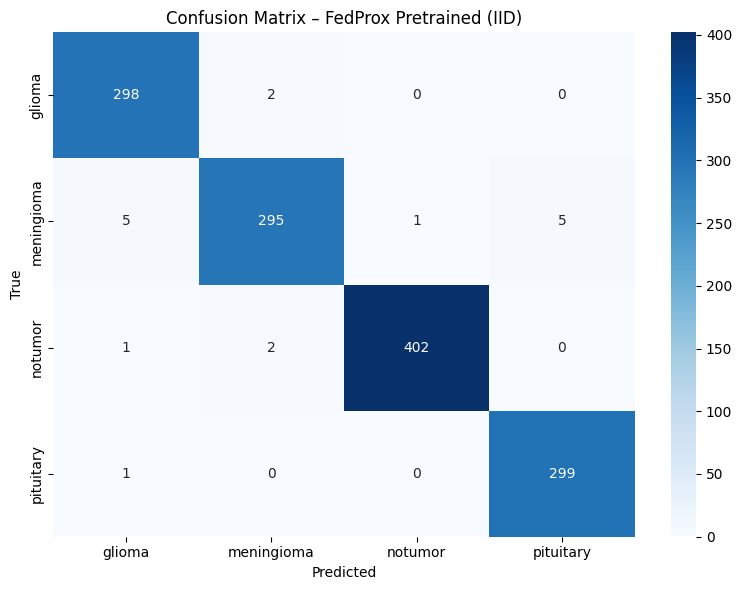

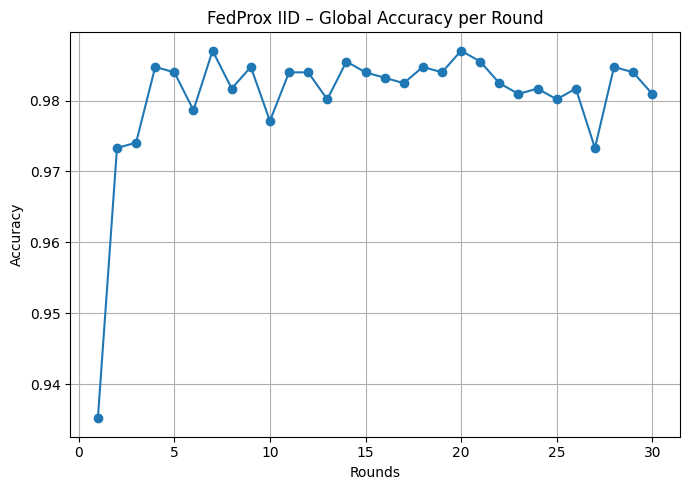

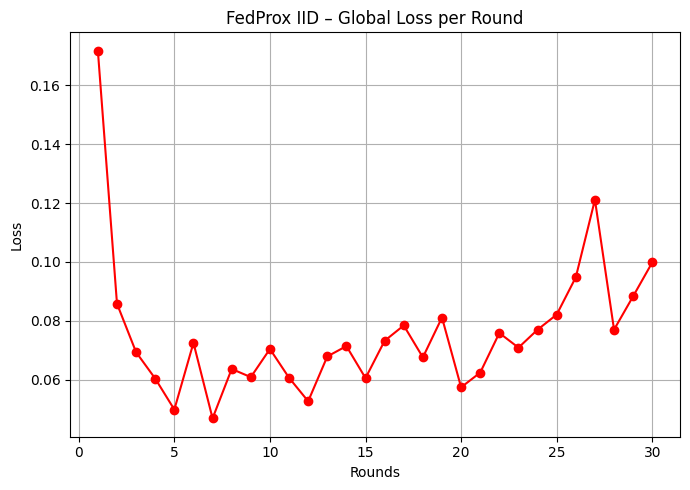

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


# ============================================================
# 1. Load IID FedProx Metrics History
# ============================================================
history_fp_iid = np.load("metrics_history_fedprox_pretrained_iid.npy", allow_pickle=True).item()

rounds_fp_iid   = history_fp_iid["round"]
holdout_fp_iid  = history_fp_iid["holdout"]

accs_fp_iid  = [m["acc"] for m in holdout_fp_iid]
losses_fp_iid = [m["loss"] for m in holdout_fp_iid]

print("FedProx IID rounds:", len(rounds_fp_iid))


# ============================================================
# 2. Recreate FedProx IID Model Architecture
# ============================================================
def create_pretrained_resnet18_iid_fp(num_classes: int):
    from torchvision import models
    import torch.nn as nn

    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Frozen layers
    for p in model.conv1.parameters():  p.requires_grad = False
    for p in model.bn1.parameters():    p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Trainable layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    return model


# ============================================================
# 3. Load Best FedProx IID Model
# ============================================================
best_model_fp_iid = create_pretrained_resnet18_iid_fp(NUM_CLASSES_IID).to(DEVICE)
best_model_fp_iid.load_state_dict(
    torch.load("best_fedprox_pretrained_iid.pth", map_location=DEVICE)
)
best_model_fp_iid.eval()

print("Loaded best FedProx IID model ✔")


# ============================================================
# 4. Evaluate on IID FedProx Global Holdout (test_dataset)
# ============================================================
all_preds = []
all_labels = []

criterion = torch.nn.CrossEntropyLoss()
total_loss = 0
total_samples = 0

with torch.no_grad():
    for x, y in holdout_loader_iid_fp:  # <-- from corrected FedProx script
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = best_model_fp_iid(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

final_acc  = (all_preds == all_labels).mean()
final_loss = total_loss / total_samples
precision  = precision_score(all_labels, all_preds, average="macro", zero_division=0)
recall     = recall_score(all_labels, all_preds, average="macro", zero_division=0)
f1         = f1_score(all_labels, all_preds, average="macro", zero_division=0)

print("\n=========== FEDPROX (IID) FINAL METRICS ===========")
print(f"Accuracy : {final_acc:.4f}")
print(f"Loss     : {final_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("===================================================\n")


# ============================================================
# 5. Confusion Matrix
# ============================================================
cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=class_names, yticklabels=class_names
)
plt.title("Confusion Matrix – FedProx Pretrained (IID)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# ============================================================
# 6. Accuracy Curve
# ============================================================
plt.figure(figsize=(7, 5))
plt.plot(rounds_fp_iid, accs_fp_iid, marker="o")
plt.title("FedProx IID – Global Accuracy per Round")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


# ============================================================
# 7. Loss Curve
# ============================================================
plt.figure(figsize=(7, 5))
plt.plot(rounds_fp_iid, losses_fp_iid, marker="o", color="red")
plt.title("FedProx IID – Global Loss per Round")
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


Using: mps

====== FedAvg IID Results ======
acc: 0.9886
loss: 0.0671
precision: 0.9878
recall: 0.9877
f1: 0.9877

====== FedProx IID Results ======
acc: 0.9870
loss: 0.0468
precision: 0.9862
recall: 0.9867
f1: 0.9864


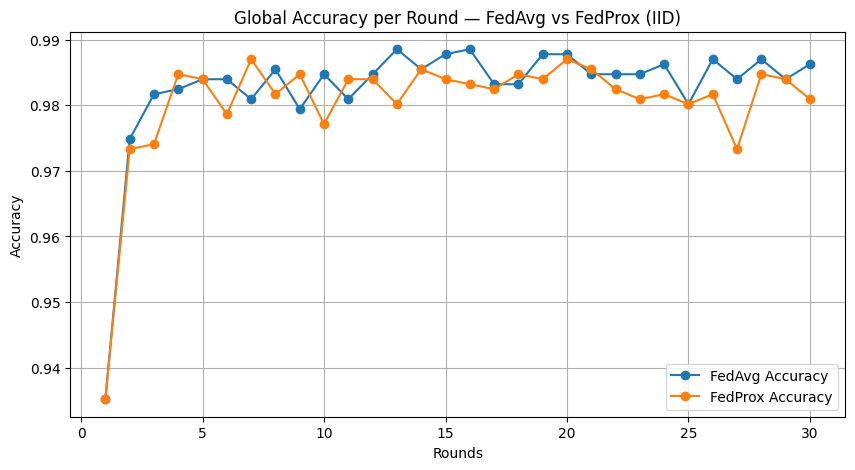

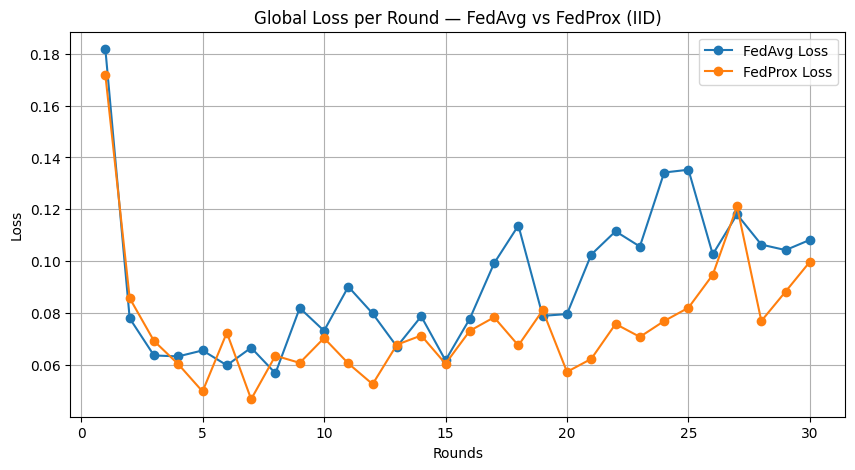

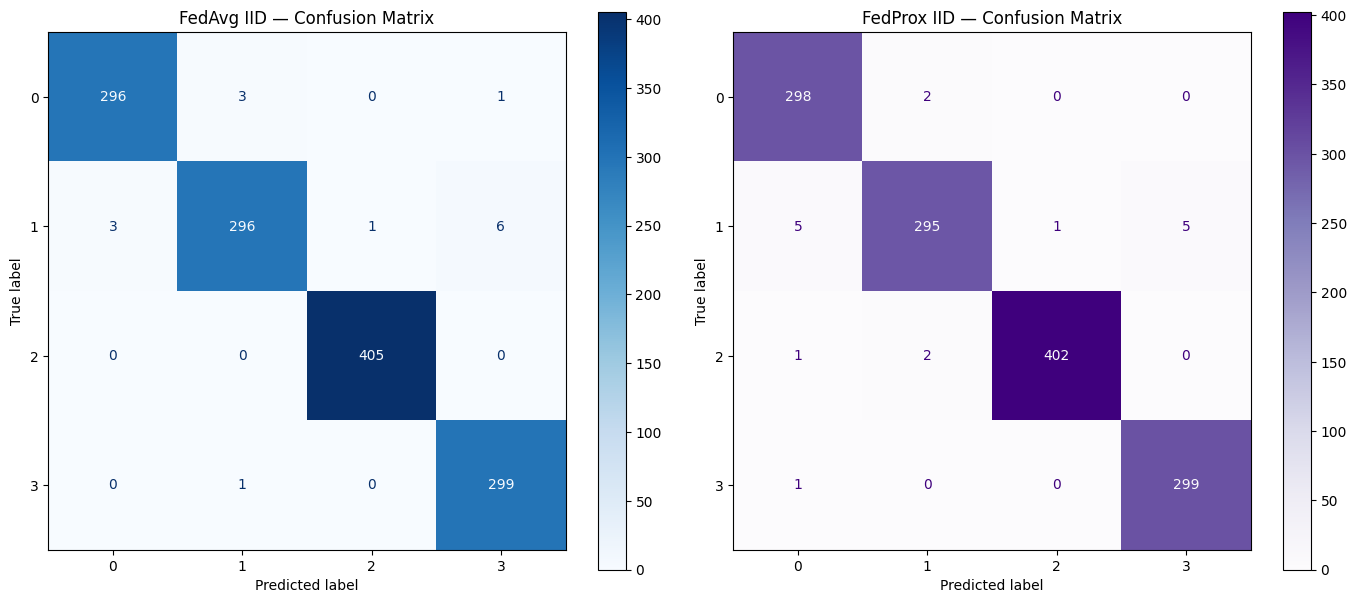

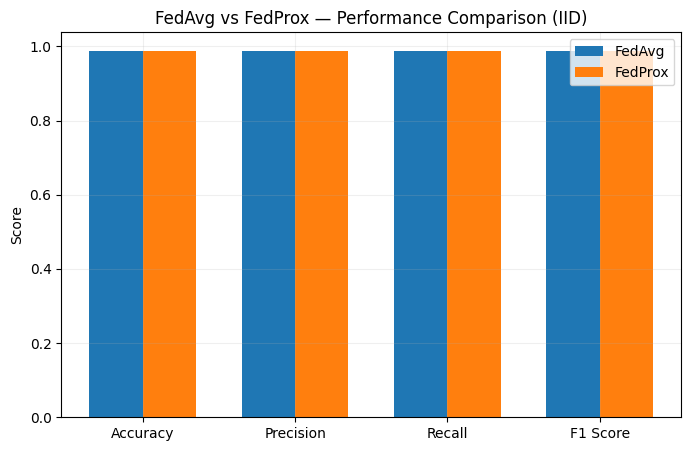

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)
import torch.nn as nn
from torchvision import models
import seaborn as sns


# ============================================================
# DEVICE
# ============================================================
DEVICE = torch.device("mps" if torch.backends.mps.is_available()
          else "cuda" if torch.cuda.is_available()
          else "cpu")

print("Using:", DEVICE)


# ============================================================
# MODEL REBUILDER (FedAvg + FedProx)
# Must match pretrained architecture used in training
# ============================================================
def create_resnet18_pretrained_eval(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Match training-time layer freezing (though eval ignores requires_grad)
    for p in model.conv1.parameters():  p.requires_grad = False
    for p in model.bn1.parameters():    p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace FC (same as training)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model


# ============================================================
# LOAD METRICS
# ============================================================
fedavg_hist = np.load("metrics_history_fedavg_iid_pretrained.npy",
                      allow_pickle=True).item()

fedprox_hist = np.load("metrics_history_fedprox_pretrained_iid.npy",
                       allow_pickle=True).item()

rounds_fa = fedavg_hist["round"]
rounds_fp = fedprox_hist["round"]

acc_fa  = [h["acc"] for h in fedavg_hist["holdout"]]
acc_fp  = [h["acc"] for h in fedprox_hist["holdout"]]

loss_fa = [h["loss"] for h in fedavg_hist["holdout"]]
loss_fp = [h["loss"] for h in fedprox_hist["holdout"]]


# ============================================================
# LOAD TRAINED MODELS
# ============================================================
fedavg_model = create_resnet18_pretrained_eval(NUM_CLASSES_IID).to(DEVICE)
fedavg_model.load_state_dict(torch.load("best_fedavg_iid_pretrained.pth",
                                        map_location=DEVICE))
fedavg_model.eval()

fedprox_model = create_resnet18_pretrained_eval(NUM_CLASSES_IID).to(DEVICE)
fedprox_model.load_state_dict(torch.load("best_fedprox_pretrained_iid.pth",
                                         map_location=DEVICE))
fedprox_model.eval()

criterion = nn.CrossEntropyLoss()


# ============================================================
# EVALUATION FUNCTION
# ============================================================
def evaluate_full(model, loader):
    model.eval()
    total_loss = 0
    total = 0

    preds_all = []
    labels_all = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * x.size(0)
            total += x.size(0)

            preds = logits.argmax(dim=1)
            preds_all.append(preds.cpu())
            labels_all.append(y.cpu())

    preds_all = torch.cat(preds_all).numpy()
    labels_all = torch.cat(labels_all).numpy()

    return {
        "acc": (preds_all == labels_all).mean(),
        "loss": total_loss / total,
        "precision": precision_score(labels_all, preds_all, average="macro", zero_division=0),
        "recall": recall_score(labels_all, preds_all, average="macro", zero_division=0),
        "f1": f1_score(labels_all, preds_all, average="macro", zero_division=0),
        "preds": preds_all,
        "labels": labels_all
    }


# ============================================================
# FINAL EVALUATION
# ============================================================
fa_final = evaluate_full(fedavg_model, holdout_loader_iid_fp)
fp_final = evaluate_full(fedprox_model, holdout_loader_iid_fp)

print("\n====== FedAvg IID Results ======")
for k, v in fa_final.items():
    if k not in ("preds", "labels"):
        print(f"{k}: {v:.4f}")

print("\n====== FedProx IID Results ======")
for k, v in fp_final.items():
    if k not in ("preds", "labels"):
        print(f"{k}: {v:.4f}")


# ============================================================
# ACCURACY CURVE
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(rounds_fa, acc_fa, marker='o', label="FedAvg Accuracy")
plt.plot(rounds_fp, acc_fp, marker='o', label="FedProx Accuracy")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title("Global Accuracy per Round — FedAvg vs FedProx (IID)")
plt.grid()
plt.legend()
plt.show()


# ============================================================
# LOSS CURVE
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(rounds_fa, loss_fa, marker='o', label="FedAvg Loss")
plt.plot(rounds_fp, loss_fp, marker='o', label="FedProx Loss")
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.title("Global Loss per Round — FedAvg vs FedProx (IID)")
plt.grid()
plt.legend()
plt.show()


# ============================================================
# CONFUSION MATRICES (Side-by-Side)
# ============================================================
cm_fa = confusion_matrix(fa_final["labels"], fa_final["preds"])
cm_fp = confusion_matrix(fp_final["labels"], fp_final["preds"])

fig, ax = plt.subplots(1, 2, figsize=(14,6))

ConfusionMatrixDisplay(cm_fa).plot(ax=ax[0], cmap="Blues")
ConfusionMatrixDisplay(cm_fp).plot(ax=ax[1], cmap="Purples")

ax[0].set_title("FedAvg IID — Confusion Matrix")
ax[1].set_title("FedProx IID — Confusion Matrix")

plt.tight_layout()
plt.show()


# ============================================================
# BAR PLOT — ACCURACY, PRECISION, RECALL, F1
# ============================================================
labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
fa_vals = [fa_final["acc"], fa_final["precision"], fa_final["recall"], fa_final["f1"]]
fp_vals = [fp_final["acc"], fp_final["precision"], fp_final["recall"], fp_final["f1"]]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - w/2, fa_vals, w, label="FedAvg")
plt.bar(x + w/2, fp_vals, w, label="FedProx")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("FedAvg vs FedProx — Performance Comparison (IID)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()
